In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Exercise 1

In [2]:
#See Appendix 1.6 on why we are implementing the tent map like this
nearly_two = 1.99999999
#operates the tent map on a full vector, so we can pass in a vector of 3 numbers and get the next 3
def tent_map_vector(a, state):
    #We need to do different things for each component, depending on it being smaller or bigger than 0
    state[state > 0] = -nearly_two * state[state > 0] + a/2
    state[state < 0] = nearly_two * state[state < 0] + a/2

def lorenz_63_iteration(sigma, rho, beta, dt, state):
    state[0] += dt * sigma*(state[1] - state[0])
    state[1] += dt * (state[0]*(rho - state[2]) - state[1])
    state[2] += dt * (state[0]*state[1] - beta*state[2])

In [3]:
def iterate_lorenz(a, sigma, rho, beta, dt, n_observations, observation_frequency, initial_lorenz, initial_tent):
    tent = initial_tent
    lorenz = initial_lorenz
    output = np.zeros((n_observations, 3))
    #for keeping track at which time the obversation happened
    ts = np.zeros(n_observations)
    output[0, :] = lorenz
    ts[0] = 0
    for i in range(1, n_observations):
        for j in range(observation_frequency):
            #these functions update lorenz and tent in place
            lorenz_63_iteration(sigma, rho, beta, dt, lorenz)
            tent_map_vector(a, tent)
            
            lorenz += dt * tent
        #copy the current state to output after every observation_frequency steps
        output[i, :] = lorenz
        ts[i] = i*dt
    return ts, output

In [4]:
initial_lorenz = np.array([-0.587, -0.563, 16.870])
sigma = 10
rho = 28
beta = 8/3

dt = 0.01
a = 1/np.sqrt(dt)
initial_tent = np.array([a*(1/2**0.5 - 0.5), a*(1/3**0.5 - 0.5), a*(1/5**0.5 - 0.5)])
n_observations = 4001
observation_frequency = 5

ts, path = iterate_lorenz(a, sigma, rho, beta, dt, n_observations, observation_frequency, initial_lorenz, initial_tent)

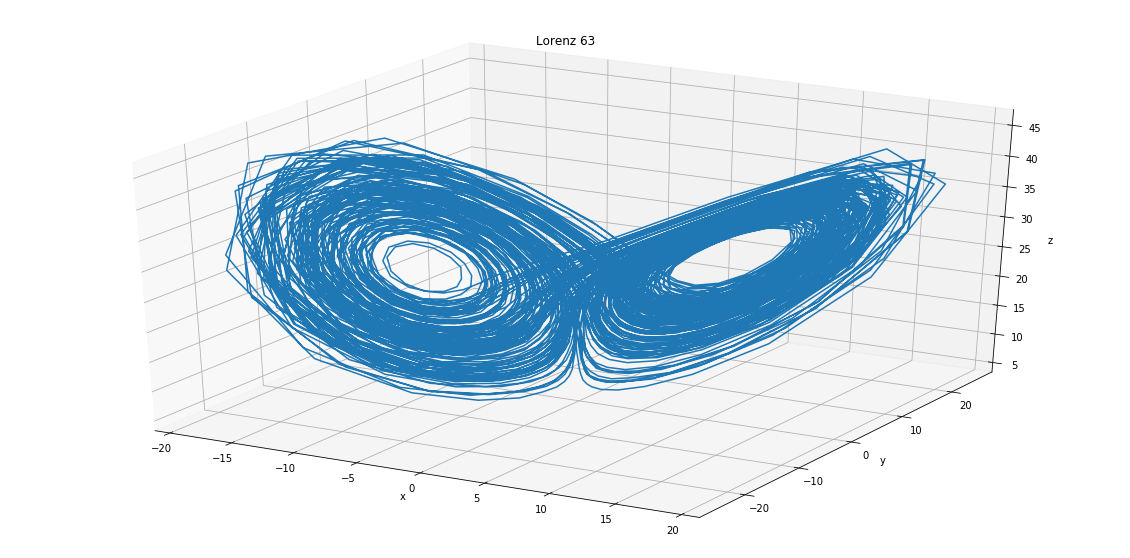

In [5]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot(path[:, 0], path[:, 1], path[:, 2])
ax.set_title('Lorenz 63')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Exercise 2

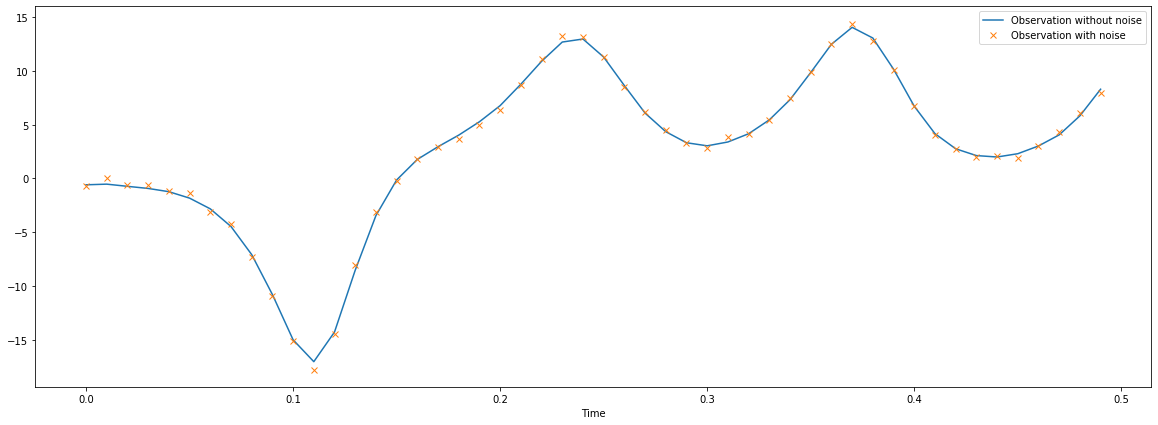

In [6]:
#this calculates the tent map for a single number only, not for a vector
def tent_map_number(a, state):
    if state > 0:
        return -nearly_two*state + a/2
    else:
        return nearly_two*state + a/2


#i as in the lecture notes, every_nth_iterate will be 10 since we only use every tenth iterate
def generate_tent_noise(a, every_nth_iterate, I, initial_tent):
    tent = initial_tent
    noise = 0
    #sum over I noise samples
    for i in range(I):
        #only use every_nth_iterate of the noise
        for j in range(every_nth_iterate):
            tent = tent_map_number(a, tent)
        noise += tent
    noise /= I
    return noise, tent

#The forward map, just taking the x-component
observations = path[:, 0].copy()
#we need to add noise to the observations
a = 4
tent = a*(1/2**0.5 - 0.5)
every_nth_iterate = 10
I = 20
#add noise to the observations we made
for i in range(n_observations):
    noise, tent = generate_tent_noise(a, every_nth_iterate, I, tent)
    observations[i] += noise
    
plt.figure(figsize=(20,7))
plt.plot(ts[:50], path[:50, 0], label="Observation without noise")
plt.plot(ts[:50], observations[:50], label="Observation with noise", marker="x", linestyle="None")
plt.xlabel("Time")
plt.legend()

# Exercise 3

Linear extrapolation works by approximating the derivative of the time series at $x_t$ by
$$\text{der}(x_t) = \frac{x_{t} - x_{t-\delta t}}{\delta t}$$

We then use our approximate derivative at $x_t$ and the value at $x_t$ to extrapolate into the future by
$$x_{t + s} = x_t + s \text{der}(x_t)$$

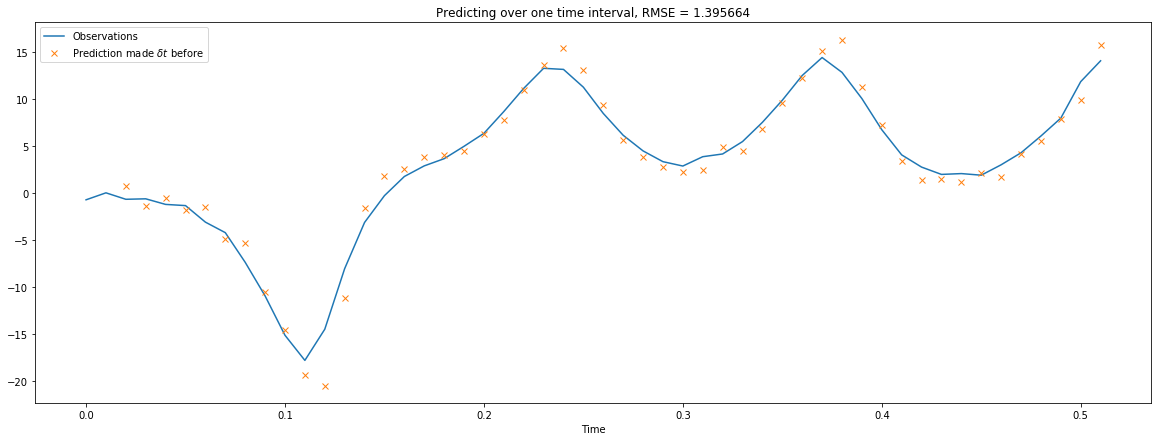

In [7]:
#takes two series and does linear ex
def linear_extrapolation(series, dt, dt_extrapolation):
    derivative = (series[1:] - series[:-1])/dt
    return series[1:] + derivative * dt_extrapolation

def rmse(series_1, series_2):
    N = series_1.shape[0]
    return np.sqrt(1/N * np.sum((series_1 - series_2)**2))

predictions_1 = linear_extrapolation(observations, dt, dt)
err = rmse(predictions_1[:-1], observations[2:])

plt.figure(figsize=(20,7))
n_plot = 50
#prediction_1 is offsetted, since the 0th entry of the prediction array is actually the prediction for
#obersations[2]. 
plt.plot(ts[:n_plot+2], observations[:2+n_plot], label="Observations")
plt.plot(ts[2:n_plot+2], predictions_1[:n_plot], label="Prediction made $\delta t$ before", marker="x", linestyle="None")
plt.xlabel("Time")
plt.title("Predicting over one time interval, RMSE = %f" % err)
plt.legend()

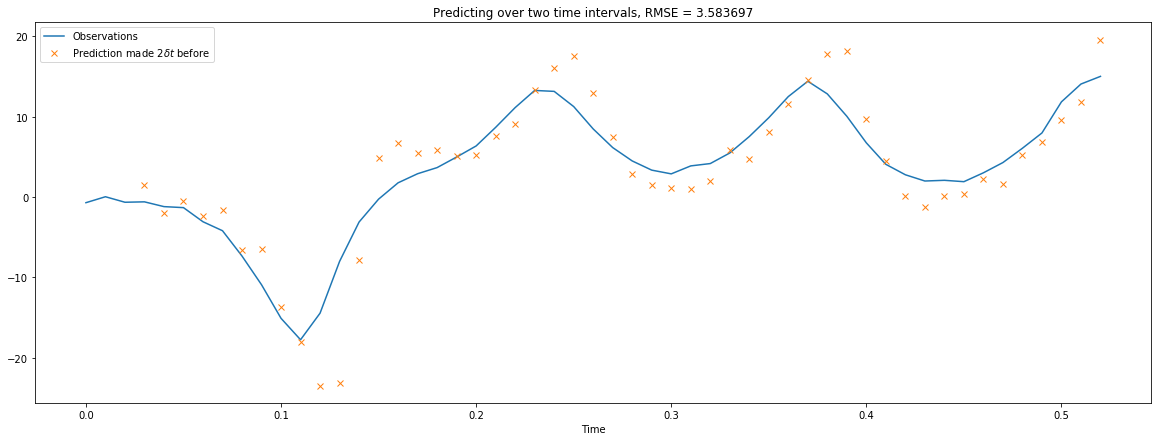

In [8]:
predictions_2 = linear_extrapolation(observations, dt, 2*dt)

#prediction_2 is offsetted, since the 0th entry of the prediction array is actually the prediction for
#obersations[3]. 
err = rmse(predictions_2[:-2], observations[3:])
plt.figure(figsize=(20,7))
plt.plot(ts[:n_plot+3], observations[:3+n_plot], label="Observations")
plt.plot(ts[3: n_plot+3], predictions_2[:n_plot], label="Prediction made $2\delta t$ before", marker="x", linestyle="None")
plt.xlabel("Time")
plt.title("Predicting over two time intervals, RMSE = %f" % err)

plt.legend()